In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid, train_test_split
from datetime import datetime, timedelta
import calendar as calendar
import datetime
sb.set()

In [2]:
df = pd.read_csv('carpark_availability_cleaned.csv')
holidays_df = pd.read_csv('sg_holidays.csv')
carpark_info = pd.read_csv('carpark_info_cleaned.csv')

In [3]:
carpark_arr = df.carpark_number.unique()

In [4]:


tempDf = df.copy()
tempDf.insert(0, 'id', range(0, len(tempDf)))

trainDf = pd.DataFrame()
# Split Data based on individual carpark, day and hour
for carpark_num in range(len(carpark_arr)):
    print("Parsing " + carpark_arr[carpark_num])
    for days in range(0,7):
        for hours in range(0,24):
            trainDf = pd.concat([trainDf, 
                                 tempDf[(tempDf['carpark_number'] == 
                                 carpark_arr[carpark_num]) & (tempDf['day'] == days) & (tempDf['hour'] == hours)].sample(frac=0.8,random_state=500)]) # Train
#     trainDf = pd.concat([trainDf, tempDf[(tempDf['carpark_number'] == carpark_arr[carpark_num])].sample(frac=0.8,random_state=500)]) # Train
print("Completed")



Parsing J70
Parsing J85M
Parsing J72
Parsing J69
Parsing JM31
Parsing J62M
Parsing J63
Parsing J83M
Parsing J67
Parsing JM2
Completed


In [5]:


trainDf.head(5)



,id,carpark_number,update_datetime,total_lots,lots_available,hour_delta,day,hour,carpark_index,holiday
4200,4200,J70,2018-06-25 00:00:00,151,0,4200.0,0,0,0,0
32240,32240,J70,2021-09-06 00:00:00,147,0,32256.0,0,0,0,0
14448,14448,J70,2019-08-26 00:00:00,147,0,14448.0,0,0,0,0
33416,33416,J70,2021-10-25 00:00:00,147,0,33432.0,0,0,0,0
34921,34921,J70,2021-12-27 00:00:00,147,0,34944.0,0,0,0,0


In [6]:
testDf = tempDf[~tempDf['id'].isin(trainDf['id'])] #Test
testDf.head(5)

,id,carpark_number,update_datetime,total_lots,lots_available,hour_delta,day,hour,carpark_index,holiday
199,199,J70,2018-01-09 07:00:00,151,17,199.0,1,7,0,0
336,336,J70,2018-01-15 00:00:00,151,0,336.0,0,0,0,0
337,337,J70,2018-01-15 01:00:00,151,0,337.0,0,1,0,0
338,338,J70,2018-01-15 02:00:00,151,0,338.0,0,2,0,0
339,339,J70,2018-01-15 03:00:00,151,0,339.0,0,3,0,0


Splitting the dataset

In [7]:


trainDf = trainDf.drop(columns=['id'])
testDf = testDf.drop(columns=['id'])
trainDf = trainDf.reset_index(drop=True)
testDf = testDf.reset_index(drop=True)



In [8]:
print("Train Shape: " + str(trainDf.shape))
print("Test Shape: " + str(testDf.shape))

Train Shape: (280160, 9)
Test Shape: (70034, 9)


In [9]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, cross_val_predict

In [10]:
def dt_reg_individual(carpark):
    rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
    print("Training " + carpark)
    trainDf2 = trainDf[trainDf['carpark_number'] == carpark]
    testDf2 = testDf[testDf['carpark_number'] == carpark]
    
    trainX = trainDf2[['day','hour','hour_delta']]
    trainY = trainDf2['lots_available'].values
    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values

    model_dtreg = rfr.fit(X_train, np.ravel(y_train))
    print(model_dtreg.score(testX, testY))
    
    return model_dtreg

In [11]:
dtreg_predictions = {} # Dictionary for Decision Tree Models

dtreg_CV = pd.DataFrame(columns=["carpark","trainCV","testCV"])

for carpark in carpark_arr:
    dtreg =  RandomForestRegressor(n_estimators = 500, random_state = 0)
    # print("Training " + carpark)
    trainDf2 = trainDf[trainDf['carpark_number'] == carpark]
    testDf2 = testDf[testDf['carpark_number'] == carpark]

    trainX = trainDf2[['day','hour','hour_delta']]
    trainY = trainDf2['lots_available'].values

    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values

    model_dtreg = dtreg.fit(trainX,trainY)
#     print("Carpark " + str(carpark_arr[0]) + " 10-K Fold Cross Validation:" )
    
    cv10_score = cross_val_score(model_dtreg,trainX, trainY, scoring="r2", cv=10)
#     print("Train K-Fold Average: " + np.mean(cv10_score))
    
    pred_score = cross_val_score(model_dtreg,  testX, testY, scoring="r2", cv=10)
    print(pred_score)
#     print("Test K-Fold Average: " + np.mean(pred_score))

    
    dtreg_append = {'carpark':carpark, 'trainCV': np.mean(cv10_score), 'testCV': np.mean(pred_score)}
    dtreg_CV = dtreg_CV.append(dtreg_append,ignore_index=True)
    
    #   Take Average Of Data For Graph Plotting
    testDf2 = testDf2.groupby(['day','hour','hour_delta'], as_index = False)['lots_available'].mean()

    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values
    
    predict_Y = cross_val_predict(model_dtreg, testX, testY)
    
#     predict_Y = model_dtreg.predict(testX)
    
    testDf2["predicted_lots"] = predict_Y.tolist()

    testDf2['day_hour'] = testDf2['day'].astype(str) + "-" + testDf2['hour'].astype(str)

    dtreg_predictions[carpark] = testDf2.copy()

with pd.option_context('display.max_rows', None,
                   'display.max_columns', None,
                   'display.width', 1000,
                   'display.precision', 3,
                   'display.colheader_justify', 'center'):
    print("Cross-validation 10-Folds Average")
    display(dtreg_CV)

[ 0.53896106  0.4087633   0.30755963 -0.11709952  0.89000531  0.79119329
  0.85296635  0.89957117  0.84360144  0.71927688]
[ 0.93963854  0.95589274  0.94024797 -0.17560551  0.39615662 -0.64517435
  0.90966313  0.95488756  0.87861915  0.86482896]
[ 0.87498411  0.93017651  0.90444989  0.92244254 -0.83265825  0.54556196
  0.91040773  0.87346375  0.89324466  0.78314789]
[-0.13485267  0.03120369 -0.10931383 -0.44495479  0.77290353  0.8730373
  0.96235818  0.93905179  0.88575558  0.75084511]
[-0.26600241  0.29813323 -0.36067251 -0.22305559 -0.82704118  0.41860836
 -0.44571053 -0.03204791  0.05140092 -0.43118488]
[ 0.31063943  0.40717377 -0.10272478 -0.58792212 -0.52997193 -0.62515972
  0.88199704  0.85020775  0.72697524  0.44561054]
[0.86230271 0.52928791 0.40044457 0.25425447 0.27945735 0.62623465
 0.82479684 0.82389427 0.62702809 0.84551337]
[ 0.83730631  0.93145265  0.81816507 -0.29063741  0.31411063  0.29695519
  0.93977356  0.94680566  0.87632451  0.88723699]
[-1.0788897  -1.51725074 -0

,carpark,trainCV,testCV
0,J70,0.656,0.613
1,J85M,0.931,0.602
2,J72,0.872,0.681
3,J69,0.734,0.453
4,JM31,0.903,-0.182
5,J62M,0.942,0.178
6,J63,0.803,0.607
7,J83M,0.971,0.656
8,J67,0.578,-0.390
9,JM2,0.893,0.211


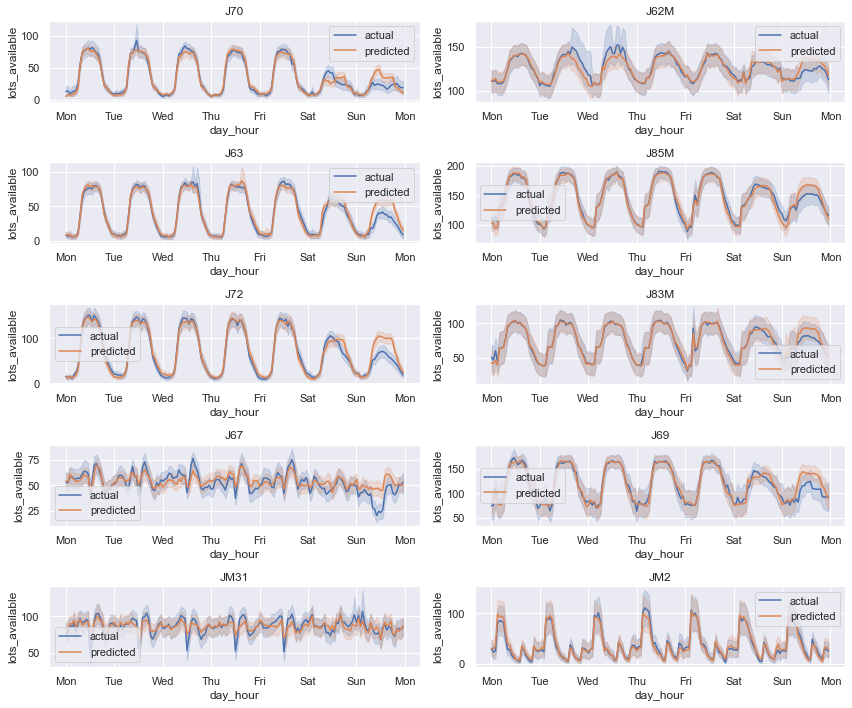

In [17]:
rows = int(len(carpark_arr)/2)
fig, axis = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(12, 10)

fig.tight_layout()

i = 0
for carpark in dtreg_predictions.keys():
    dfPlot = dtreg_predictions[carpark]
    dfPlot["day_hour"] = "2022-08-" + (dfPlot['day']+1).astype(str) + " " + dfPlot["hour"].astype(str) + ":0:0"
    dfPlot["day_hour"] = pd.to_datetime(dfPlot["day_hour"], format= "%Y-%m-%d %H:%M:%S")
    date_format =  mdates.DateFormatter("%a")
    lp1 = sb.lineplot(x='day_hour',y='lots_available', legend='brief', label="actual",data=dfPlot, ax=axis[i%rows,i%2])
    lp2 = sb.lineplot(x='day_hour',y='predicted_lots', legend='brief', label="predicted",data=dfPlot, ax=axis[i%rows,i%2])
    lp1.set(title=str(carpark_arr[i]))
    lp1.xaxis.set_major_formatter(date_format)
    lp2.xaxis.set_major_formatter(date_format)
    
    i = i + 1
fig.tight_layout()

In [ ]:
X_train.info()
print() #linebreak
X_test.info()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfrModel = rfr.fit(X_train, np.ravel(y_train))

In [ ]:
rfrModel.score(X_train, y_train)

In [ ]:
rfrModel.score(X_test, y_test)

In [ ]:
# X_train

In [ ]:
# X_test

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [ ]:
# Test Predict Carpark 4, Tuesday, 2am, 25 hours after first datapoint

rfrModel.predict([[4, 5, 1, 25]])[0]

In [ ]:
y_train_pred = rfrModel.predict(X_train)
y_test_pred = rfrModel.predict(X_test)

In [ ]:
r2_score(y_test, y_test_pred)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
cv10_score = cross_val_score(rfrModel,X_train, np.ravel(y_train), scoring="r2", cv=5)
print(np.mean(cv10_score))

pred_score = cross_val_score(rfrModel,  X_test, np.ravel(y_test), scoring="r2", cv=5)

print(np.mean(pred_score))

pred_crossval = cross_val_predict(rfrModel, X_test, np.ravel(y_test))

print(pred_crossval)